In [36]:
# 함수모음집

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from lightgbm import LGBMRegressor
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.multioutput import MultiOutputRegressor
import warnings
import os

warnings.filterwarnings('ignore', category=UserWarning)

# ==========================================
# 기초 함수 및 강화된 피처 엔지니어링 정의
# ==========================================

def add_all_year_holiday_features(data):
    def get_flower_holidays(year):
        return {
            'Graduation': pd.to_datetime(f'{year}-02-10'),
            'Valentine': pd.to_datetime(f'{year}-02-14'),
            'WhiteDay': pd.to_datetime(f'{year}-03-14'),
            'ParentsDay': pd.to_datetime(f'{year}-05-08'),
            'TeachersDay': pd.to_datetime(f'{year}-05-15'),
            'Christmas': pd.to_datetime(f'{year}-12-25')
        }
    def calculate_min_dist(row):
        curr = row['date']
        hols = list(get_flower_holidays(curr.year).values()) + list(get_flower_holidays(curr.year + 1).values())
        future = [h for h in hols if h >= curr]
        if not future: return 0
        dist = (min(future) - curr).days
        return max(0, 14 - dist) if dist <= 14 else 0
    data['holiday_impact'] = data.apply(calculate_min_dist, axis=1)
    return data

def engineer_features(df):
    epsilon = 1e-6
    # 시장 구조 피처
    df["spread"] = df["max_amount"] - df["min_amount"]
    df["premium_ratio"] = df["max_amount"] / (df["mean"] + epsilon)
    df["low_pressure"] = df["mean"] - df["min_amount"]

    # [핵심] 차기 회차 물량 배치 (사용자 고찰 반영)
    df['next_auction_qty'] = df['total_quantity'].shift(-1)
    df['next_auction_qty'] = df['next_auction_qty'].fillna(df['total_quantity'].mean())
    df["next_qty_change_ratio"] = (df["next_auction_qty"] - df["total_quantity"]) / (df["total_quantity"] + epsilon)

    # 추세 피처
    df["mean_roll7_mean"] = df["mean"].rolling(7).mean()
    df["qty_roll7_mean"] = df["total_quantity"].rolling(7).mean()

    # 날짜 피처
    df['month'] = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df = add_all_year_holiday_features(df)
    
    df = df.fillna(method='bfill').fillna(0)
    
    # 로그 변환 리스트 (next_auction_qty 포함)
    log_cols = ['max_amount', 'mean', 'min_amount', 'spread', 'total_quantity', 'next_auction_qty']
    for col in log_cols:
        df[f'log_{col}'] = np.log1p(df[col])
        
    return df


    
def create_continuous_multi_target_dataset(data, window, steps, features):
    X, y, years, rounds = [], [], [], []
    for i in range(len(data) - window - steps + 1):
        X.append(data[features].iloc[i : i + window].values.flatten())
        y_min = data['log_min_amount'].iloc[i + window : i + window + steps].values
        y_mean = data['log_mean'].iloc[i + window : i + window + steps].values
        y_max = data['log_max_amount'].iloc[i + window : i + window + steps].values
        y.append(np.concatenate([y_min, y_mean, y_max]))
        years.append(data['year'].iloc[i + window])
        rounds.append(data['auction_count'].iloc[i + window])
    return np.array(X), np.array(y), np.array(years), np.array(rounds)

# MAPE(Mean Absolute Percentage Error) 계산 함수
def calculate_mape(actual, pred):
    return np.mean(np.abs((actual - pred) / (actual + 1e-6))) * 100


def calculate_direction_accuracy(actual, pred):
    # 1. 실제 가격의 변동 방향 (이전 회차 대비)
    # actual[1:] 은 현재값, actual[:-1] 은 이전값
    actual_diff = np.diff(actual) 
    actual_direction = np.sign(actual_diff) # 상승: 1, 유지: 0, 하락: -1

    # 2. 예측 가격의 변동 방향 (실제 이전 회차 대비 예측값이 어디로 향하는지)
    # pred[1:] 은 예측된 현재값, actual[:-1] 은 실제 이전값
    pred_diff = pred[1:] - actual[:-1]
    pred_direction = np.sign(pred_diff)

    # 3. 실제 방향과 예측 방향이 일치하는지 확인
    accuracy = np.mean(actual_direction == pred_direction) * 100
    return accuracy

In [37]:
# ==========================================
# 2. 데이터 로드 및 연속형 멀티 타겟 데이터셋 생성
# ==========================================


# 데이터 불러오
base_path = './' 


# file_name = '19_25_Q1freesia_sol.CSV'
# file_name = '19_25_Q2freesia_sol.CSV'
# file_name = '19_25_Q3chrysanthemum_pode.CSV'
file_name = '19_25_Q4chrysanthemum_pode.CSV'

# 파일 존재 여부 확인 로직 (추천)
full_path = os.path.join(base_path, file_name)
if not os.path.exists(full_path):
    print(f"❌ 파일을 찾을 수 없습니다: {full_path}")
else:
    df = pd.read_csv(full_path)
    print(f"✅ 파일을 성공적으로 불러왔습니다: {file_name}")


df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df['year'] = df['date'].dt.year
df['auction_count'] = df.groupby('year').cumcount() + 1


df_std = engineer_features(df)
min_rounds = df_std[df_std['year'] <= 2024].groupby('year')['auction_count'].max().min()
df_std = df_std[df_std['auction_count'] <= min_rounds].copy()

# 학습 피처 리스트 (강화 버전)
features = [
    'log_total_quantity', 'log_next_auction_qty', 'next_qty_change_ratio',
    'log_max_amount', 'log_mean', 'log_min_amount', 'log_spread', 
    'premium_ratio', 'low_pressure', 'mean_roll7_mean', 'qty_roll7_mean',
    'holiday_impact', 'auction_count', 'month', 'dayofweek'
]

window_size, future_steps = 3, 7
X_raw, y_raw, year_indices, round_indices = create_continuous_multi_target_dataset(df_std, window_size, future_steps, features)

flat_feature_names = [f"{f}_lag{lag}" for lag in range(window_size, 0, -1) for f in features]
X_final_df = pd.DataFrame(X_raw, columns=flat_feature_names)
#현제 24년 까지가 학습데이터 
X_train, y_train = X_final_df[year_indices <= 2024], y_raw[year_indices <= 2024]
X_test, y_test = X_final_df[year_indices == 2025], y_raw[year_indices == 2025]
test_rounds = round_indices[year_indices == 2025]
# 모델 학습 (3중 타겟)
# ==========================================

lgbm = LGBMRegressor(n_estimators=300, learning_rate=0.03, num_leaves=15, max_depth=5, random_state=42, verbose=-1)
model = MultiOutputRegressor(lgbm)
model.fit(X_train, y_train)

✅ 파일을 성공적으로 불러왔습니다: 19_25_Q4chrysanthemum_pode.CSV


C:\Users\LDH\AppData\Local\Temp\ipykernel_24176\2784342232.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(0)


,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,"LGBMRegressor...2, verbose=-1)"
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,boosting_type,'gbdt'
,num_leaves,15
,max_depth,5
,learning_rate,0.03
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


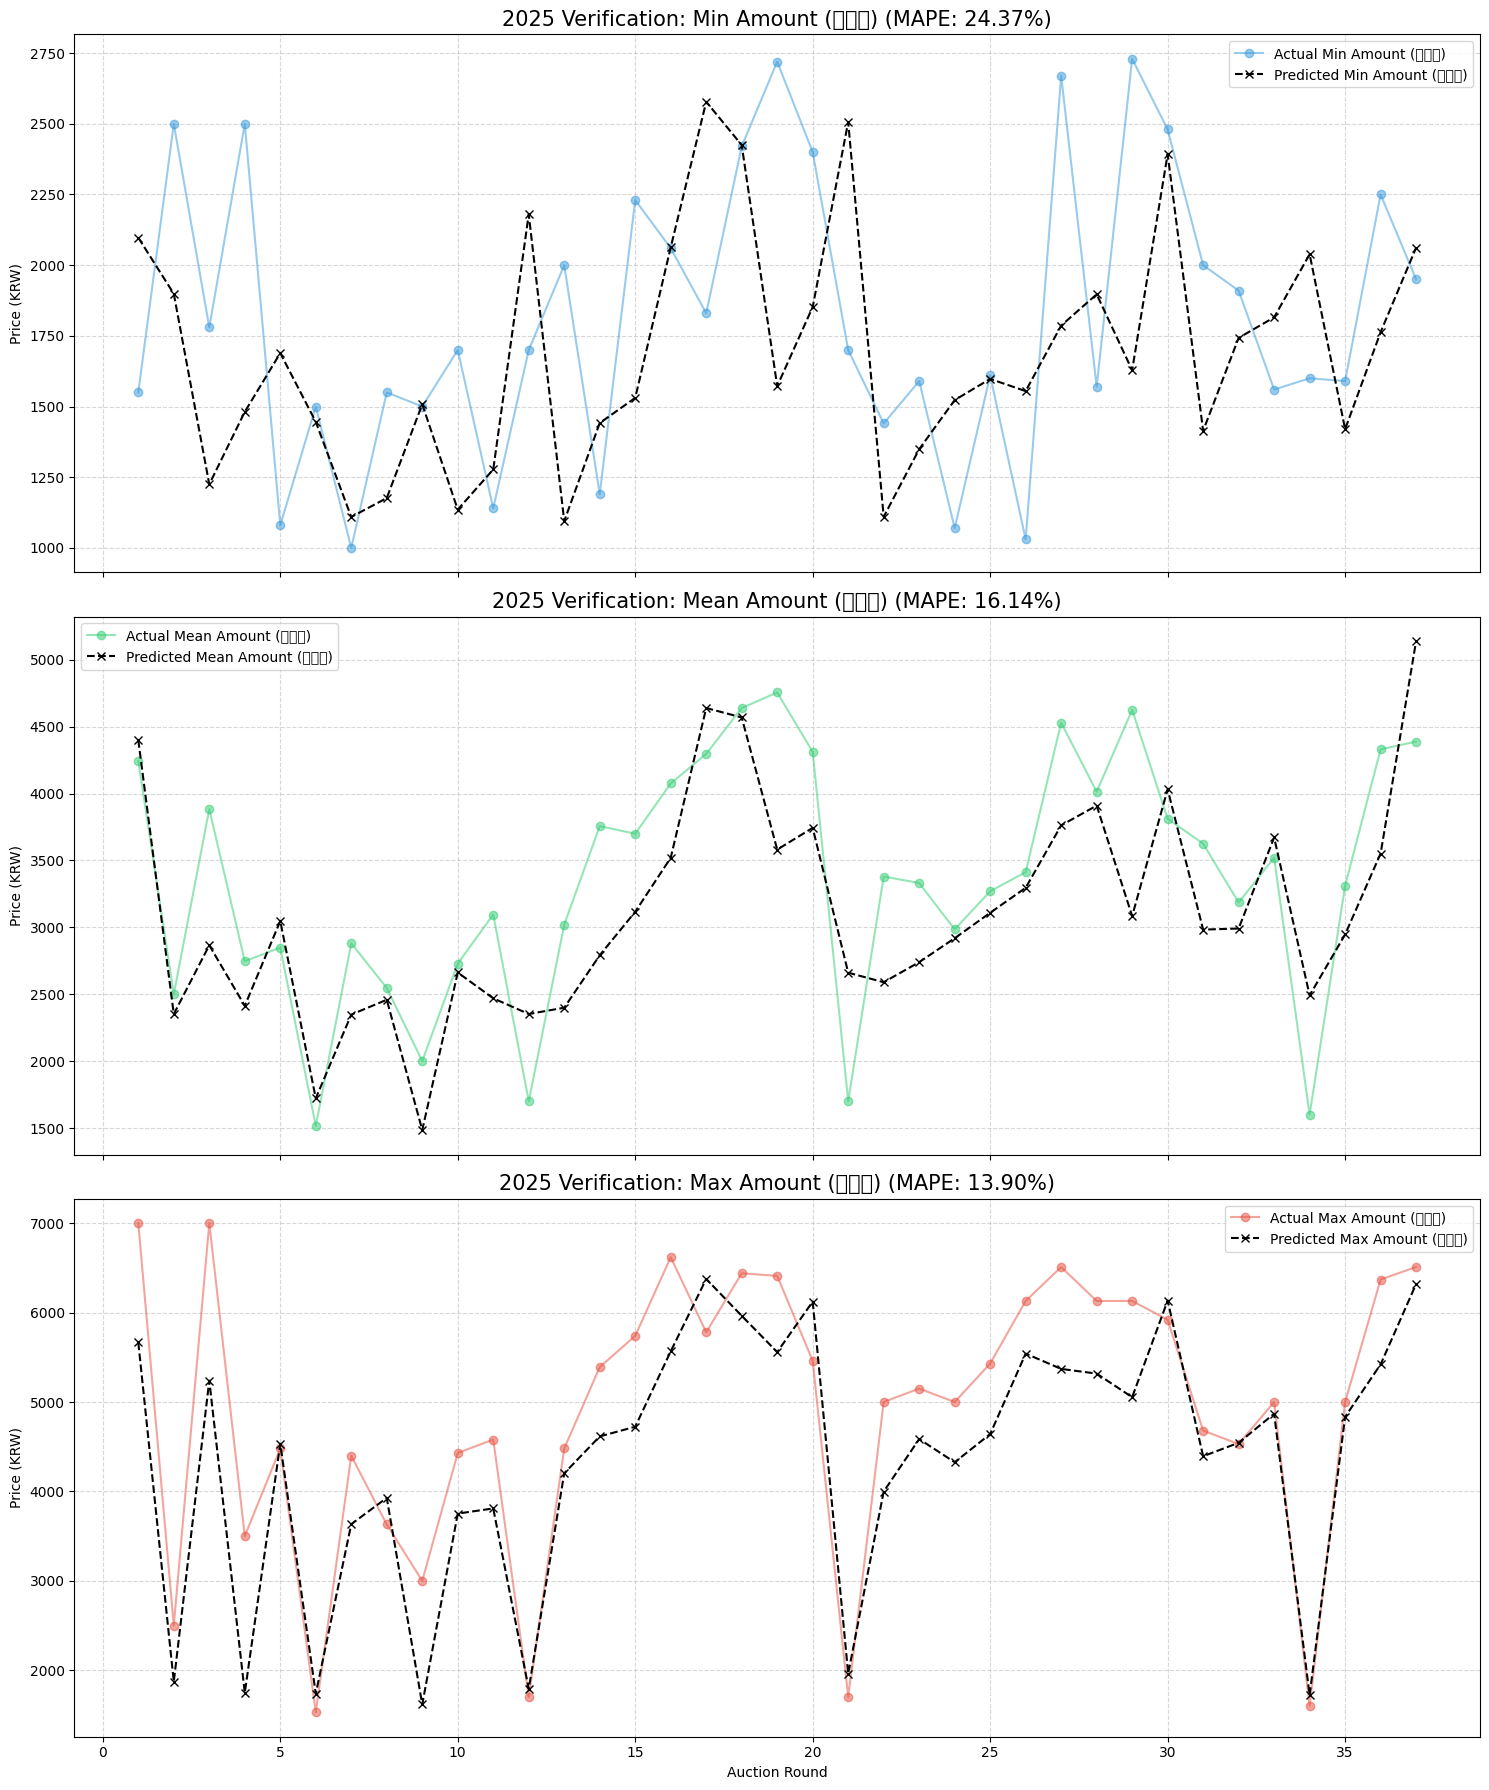

--- [2025년 모델 검증 지표 요약] ---
1. 최저가(Min) MAPE: 24.37%
2. 평균가(Mean) MAPE: 16.14%
3. 최고가(Max) MAPE: 13.90%

--- [2025년 등락 적중률(Hit Ratio) 요약] ---
1. 최저가(Min) 등락 적중률: 80.56%
2. 평균가(Mean) 등락 적중률: 86.11%
3. 최고가(Max) 등락 적중률: 75.00%


In [38]:
# 2025년 테스트 데이터 검증 및 지표 산출
# ==========================================

# 1. 2025년 테스트 데이터 예측
y_pred_log_test = model.predict(X_test)

# 2. Reshape 및 역로그 변환 (Inverse Transform)
# Shape: (샘플 수, 3지표, 7일치)
y_test_res = y_test.reshape(-1, 3, future_steps)
y_pred_res = y_pred_log_test.reshape(-1, 3, future_steps)

# 실제 가격으로 복원 (Step 1: 바로 다음 경매일 기준)
actual_min = np.expm1(y_test_res[:, 0, 0])
actual_mean = np.expm1(y_test_res[:, 1, 0])
actual_max = np.expm1(y_test_res[:, 2, 0])

pred_min = np.expm1(y_pred_res[:, 0, 0])
pred_mean = np.expm1(y_pred_res[:, 1, 0])
pred_max = np.expm1(y_pred_res[:, 2, 0])

mape_min = calculate_mape(actual_min, pred_min)
mape_mean = calculate_mape(actual_mean, pred_mean)
mape_max = calculate_mape(actual_max, pred_max)

# 4. 시각화: 3개 지표 비교 그래프
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
titles = ['Min Amount (최저가)', 'Mean Amount (평균가)', 'Max Amount (최고가)']
actuals = [actual_min, actual_mean, actual_max]
preds = [pred_min, pred_mean, pred_max]
colors = ['#3498db', '#2ecc71', '#e74c3c'] # Blue, Green, Red
mapes = [mape_min, mape_mean, mape_max]

for i in range(3):
    axes[i].plot(test_rounds, actuals[i], 'o-', label=f'Actual {titles[i]}', color=colors[i], alpha=0.5)
    axes[i].plot(test_rounds, preds[i], 'x--', label=f'Predicted {titles[i]}', color='black', linewidth=1.5)
    
    axes[i].set_title(f"2025 Verification: {titles[i]} (MAPE: {mapes[i]:.2f}%)", fontsize=15)
    axes[i].set_ylabel("Price (KRW)")
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Auction Round")
plt.tight_layout()
plt.show()

# 지표 요약 출력
print("--- [2025년 모델 검증 지표 요약] ---")
print(f"1. 최저가(Min) MAPE: {mape_min:.2f}%")
print(f"2. 평균가(Mean) MAPE: {mape_mean:.2f}%")
print(f"3. 최고가(Max) MAPE: {mape_max:.2f}%")

# 각 지표별 등락 적중률 계산
hit_min = calculate_direction_accuracy(actual_min, pred_min)
hit_mean = calculate_direction_accuracy(actual_mean, pred_mean)
hit_max = calculate_direction_accuracy(actual_max, pred_max)

print("\n--- [2025년 등락 적중률(Hit Ratio) 요약] ---")
print(f"1. 최저가(Min) 등락 적중률: {hit_min:.2f}%")
print(f"2. 평균가(Mean) 등락 적중률: {hit_mean:.2f}%")
print(f"3. 최고가(Max) 등락 적중률: {hit_max:.2f}%")

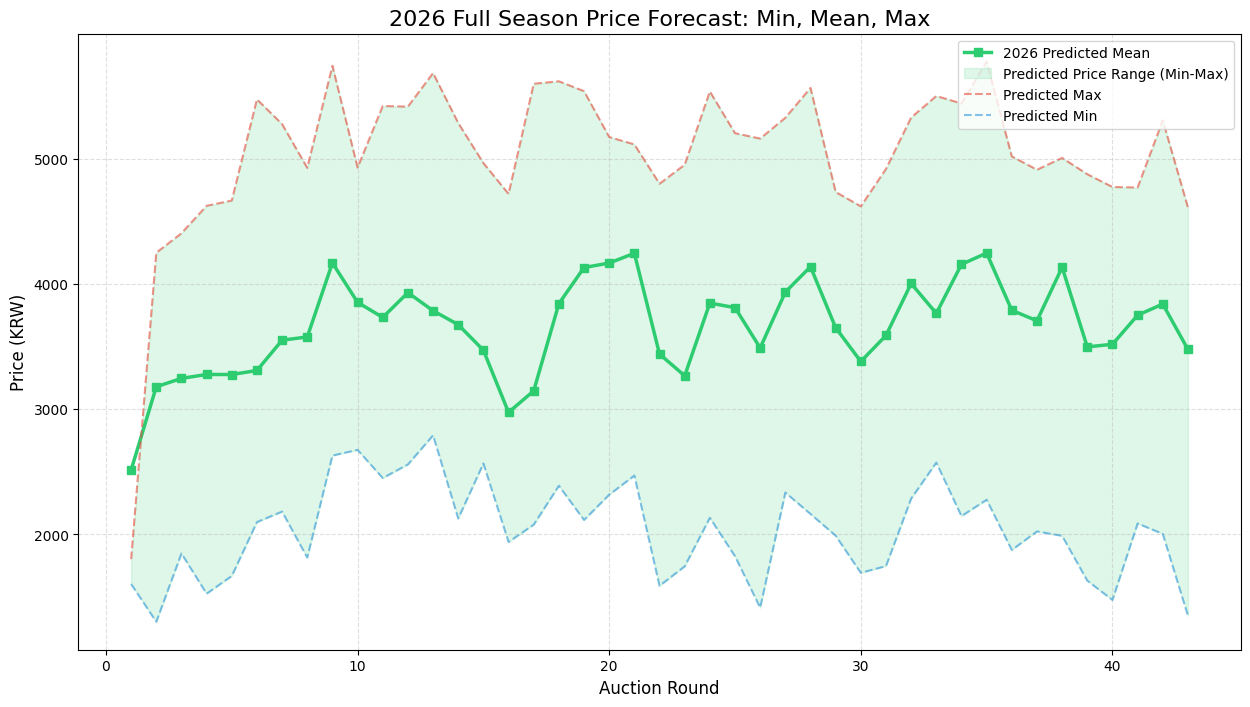

,date,auction_count,min,mean,max
0,2026-01-02,1,1603.901901,2513.646286,1802.609916
1,2026-01-05,2,1303.035600,3178.464519,4248.134222
2,2026-01-07,3,1847.957969,3245.241989,4403.201489
3,2026-01-09,4,1526.998030,3276.427261,4622.689428
4,2026-01-12,5,1668.343770,3275.997794,4664.695151
5,2026-01-14,6,2098.409604,3308.234162,5472.290619
6,2026-01-16,7,2182.136093,3550.232708,5274.665725
7,2026-01-19,8,1815.145411,3575.899660,4925.485656
8,2026-01-21,9,2629.472238,4167.062850,5740.341102
9,2026-01-23,10,2674.731135,3852.363683,4927.639932


In [35]:
# ==========================================
# 3. 2026년 재귀적 예측 (Recursive Simulation) 및 시각
# ==========================================
kr_holidays_2026 = [
    '2026-01-01', '2026-02-16', '2026-02-17', '2026-02-18', 
    '2026-03-02', '2026-05-05', '2026-05-25', '2026-08-17', 
    '2026-09-24', '2026-09-25', '2026-09-26', '2026-09-28', 
    '2026-10-05', '2026-10-09', '2026-12-25'
]

auc_cal_2026 = CustomBusinessDay(weekmask='Mon Wed Fri', holidays=kr_holidays_2026)
start_date_2026 = pd.to_datetime('2026-01-02') 

# 회차별 평균 물량
avg_qty_by_round = df_std.groupby('auction_count')['total_quantity'].mean()

# 시작 윈도우 (2025년 마지막 3일)
current_x = df_std[df_std['year'] == 2025].tail(window_size)[features].values.flatten().tolist()
forecast_2026 = []

for r in range(1, min_rounds + 1):
    X_input = pd.DataFrame([current_x], columns=flat_feature_names)
    pred_log = model.predict(X_input)[0]
    
    # 결과 저장 (Min, Mean, Max)
    curr_date = start_date_2026 + ((r-1) * auc_cal_2026)
    forecast_2026.append({
        'date': curr_date, 'auction_count': r,
        'min': np.expm1(pred_log[0]), 'mean': np.expm1(pred_log[7]), 'max': np.expm1(pred_log[14])
    })
    
    # [핵심] 다음 회차를 위한 윈도우 업데이트 (내일 물량 정보 주입)
    if r < min_rounds:
        next_date = start_date_2026 + (r * auc_cal_2026)
        curr_qty = avg_qty_by_round.get(r, avg_qty_by_round.mean())
        next_qty = avg_qty_by_round.get(r+1, avg_qty_by_round.mean()) # 선행 물량 정보
        
        # 오늘 예측된 가격 로그값
        p_min, p_mean, p_max = pred_log[0], pred_log[7], pred_log[14]
        
        tmp_impact = add_all_year_holiday_features(pd.DataFrame({'date': [next_date]}))['holiday_impact'].iloc[0]
        
        next_row = [
            np.log1p(curr_qty), np.log1p(next_qty), (next_qty - curr_qty)/(curr_qty + 1e-6),
            p_max, p_mean, p_min, np.log1p(np.expm1(p_max)-np.expm1(p_min)),
            np.expm1(p_max)/(np.expm1(p_mean)+1e-6), np.expm1(p_mean)-np.expm1(p_min),
            p_mean, np.log1p(curr_qty), tmp_impact, r+1, next_date.month, next_date.dayofweek
        ]
        current_x = current_x[len(features):] + next_row


df_2026 = pd.DataFrame(forecast_2026)

# 4. 2026년 예측 그래프 시각화 (Min, Mean, Max)
# ==========================================
plt.figure(figsize=(15, 8))

# 평균가 실선
plt.plot(df_2026['auction_count'], df_2026['mean'], 's-', label='2026 Predicted Mean', color='#2ecc71', linewidth=2.5)

# 최저/최고가 범위 (음영 처리)
plt.fill_between(df_2026['auction_count'], df_2026['min'], df_2026['max'], 
                 color='#2ecc71', alpha=0.15, label='Predicted Price Range (Min-Max)')

# 최저/최고가 점선
plt.plot(df_2026['auction_count'], df_2026['max'], '--', color='#e74c3c', alpha=0.6, label='Predicted Max')
plt.plot(df_2026['auction_count'], df_2026['min'], '--', color='#3498db', alpha=0.6, label='Predicted Min')

plt.title("2026 Full Season Price Forecast: Min, Mean, Max", fontsize=16)
plt.xlabel("Auction Round", fontsize=12)
plt.ylabel("Price (KRW)", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

display(df_2026[['date', 'auction_count', 'min', 'mean', 'max']].head(15))